# 04 - Crisis Analysis & Portfolio Backtesting
## Risk Parity Portfolio Project

**Objective**: Evaluate portfolio performance during financial crises

### Sections:
1. Backtest all portfolios
2. Analyze crisis performance (GFC, COVID, Inflation)
3. Compare drawdowns
4. Calculate comprehensive metrics
5. Final conclusions

In [1]:
# Imports
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from src.data_loader import DataLoader
from src.risk_models import RiskModels
from src.optimizer import PortfolioOptimizer
from src.backtester import PortfolioBacktester
from src.visualization import PortfolioVisualizer

import warnings
warnings.filterwarnings('ignore')

plt.style.use('dark_background')
STONKS_GREEN = '#00ff9c'
STONKS_RED = '#ff005c'
STONKS_BLUE = '#00c3ff'
STONKS_PURP = '#9d4edd'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\computation\expressions.py:22: UserWarning: Pandas requires version '2.10.2' or newer of 'numexpr' (version '2.8.7' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\rfull\AppData\Roaming\Python\Python312\site-packages\pandas\core\arrays\masked.py:56: UserWarning: Pandas requires version '1.4.2' or newer of 'bottleneck' (version '1.3.7' currently installed).
  from pandas.core import (


## 1. Load Data & Optimize Portfolios

In [2]:
# Load data
loader = DataLoader(fred_api_key="9fb3507ccba20e766e4972a45c57c18c")
prices = loader.load_data('../data/raw_prices.csv')
returns = RiskModels.calculate_returns(prices, method='log')

# Calculate covariance
cov_matrix = RiskModels.calculate_covariance_matrix(returns)

# Optimize portfolios
optimizer = PortfolioOptimizer(cov_matrix, asset_names=list(returns.columns))
rp_result = optimizer.optimize_risk_parity()

# Benchmark portfolios
sixty_forty_weights = optimizer.sixty_forty_portfolio(list(returns.columns))
equal_weights = optimizer.equal_weight_portfolio(len(returns.columns))

print("✅ Portfolios optimized")


📂 Loaded cached data → (2567, 3)
✅ Portfolios optimized


## 2. Backtest All Portfolios

In [6]:
# Initialize backtester
backtester = PortfolioBacktester(prices, returns)

# Backtest strategies
strategies = {
    'Risk Parity': rp_result['weights'],
    '60/40': sixty_forty_weights,
    'Equal-Weight': equal_weights
}

performance = backtester.backtest_multiple_strategies(strategies)

print("✅ Backtest complete")
print(f"\nFinal Values (Starting from $1.00):")
print(performance.iloc[-1].round(3))

✅ Backtest complete

Final Values (Starting from $1.00):
Risk Parity     2.116
60/40           2.210
Equal-Weight    1.980
Name: 2026-02-02 00:00:00, dtype: float64


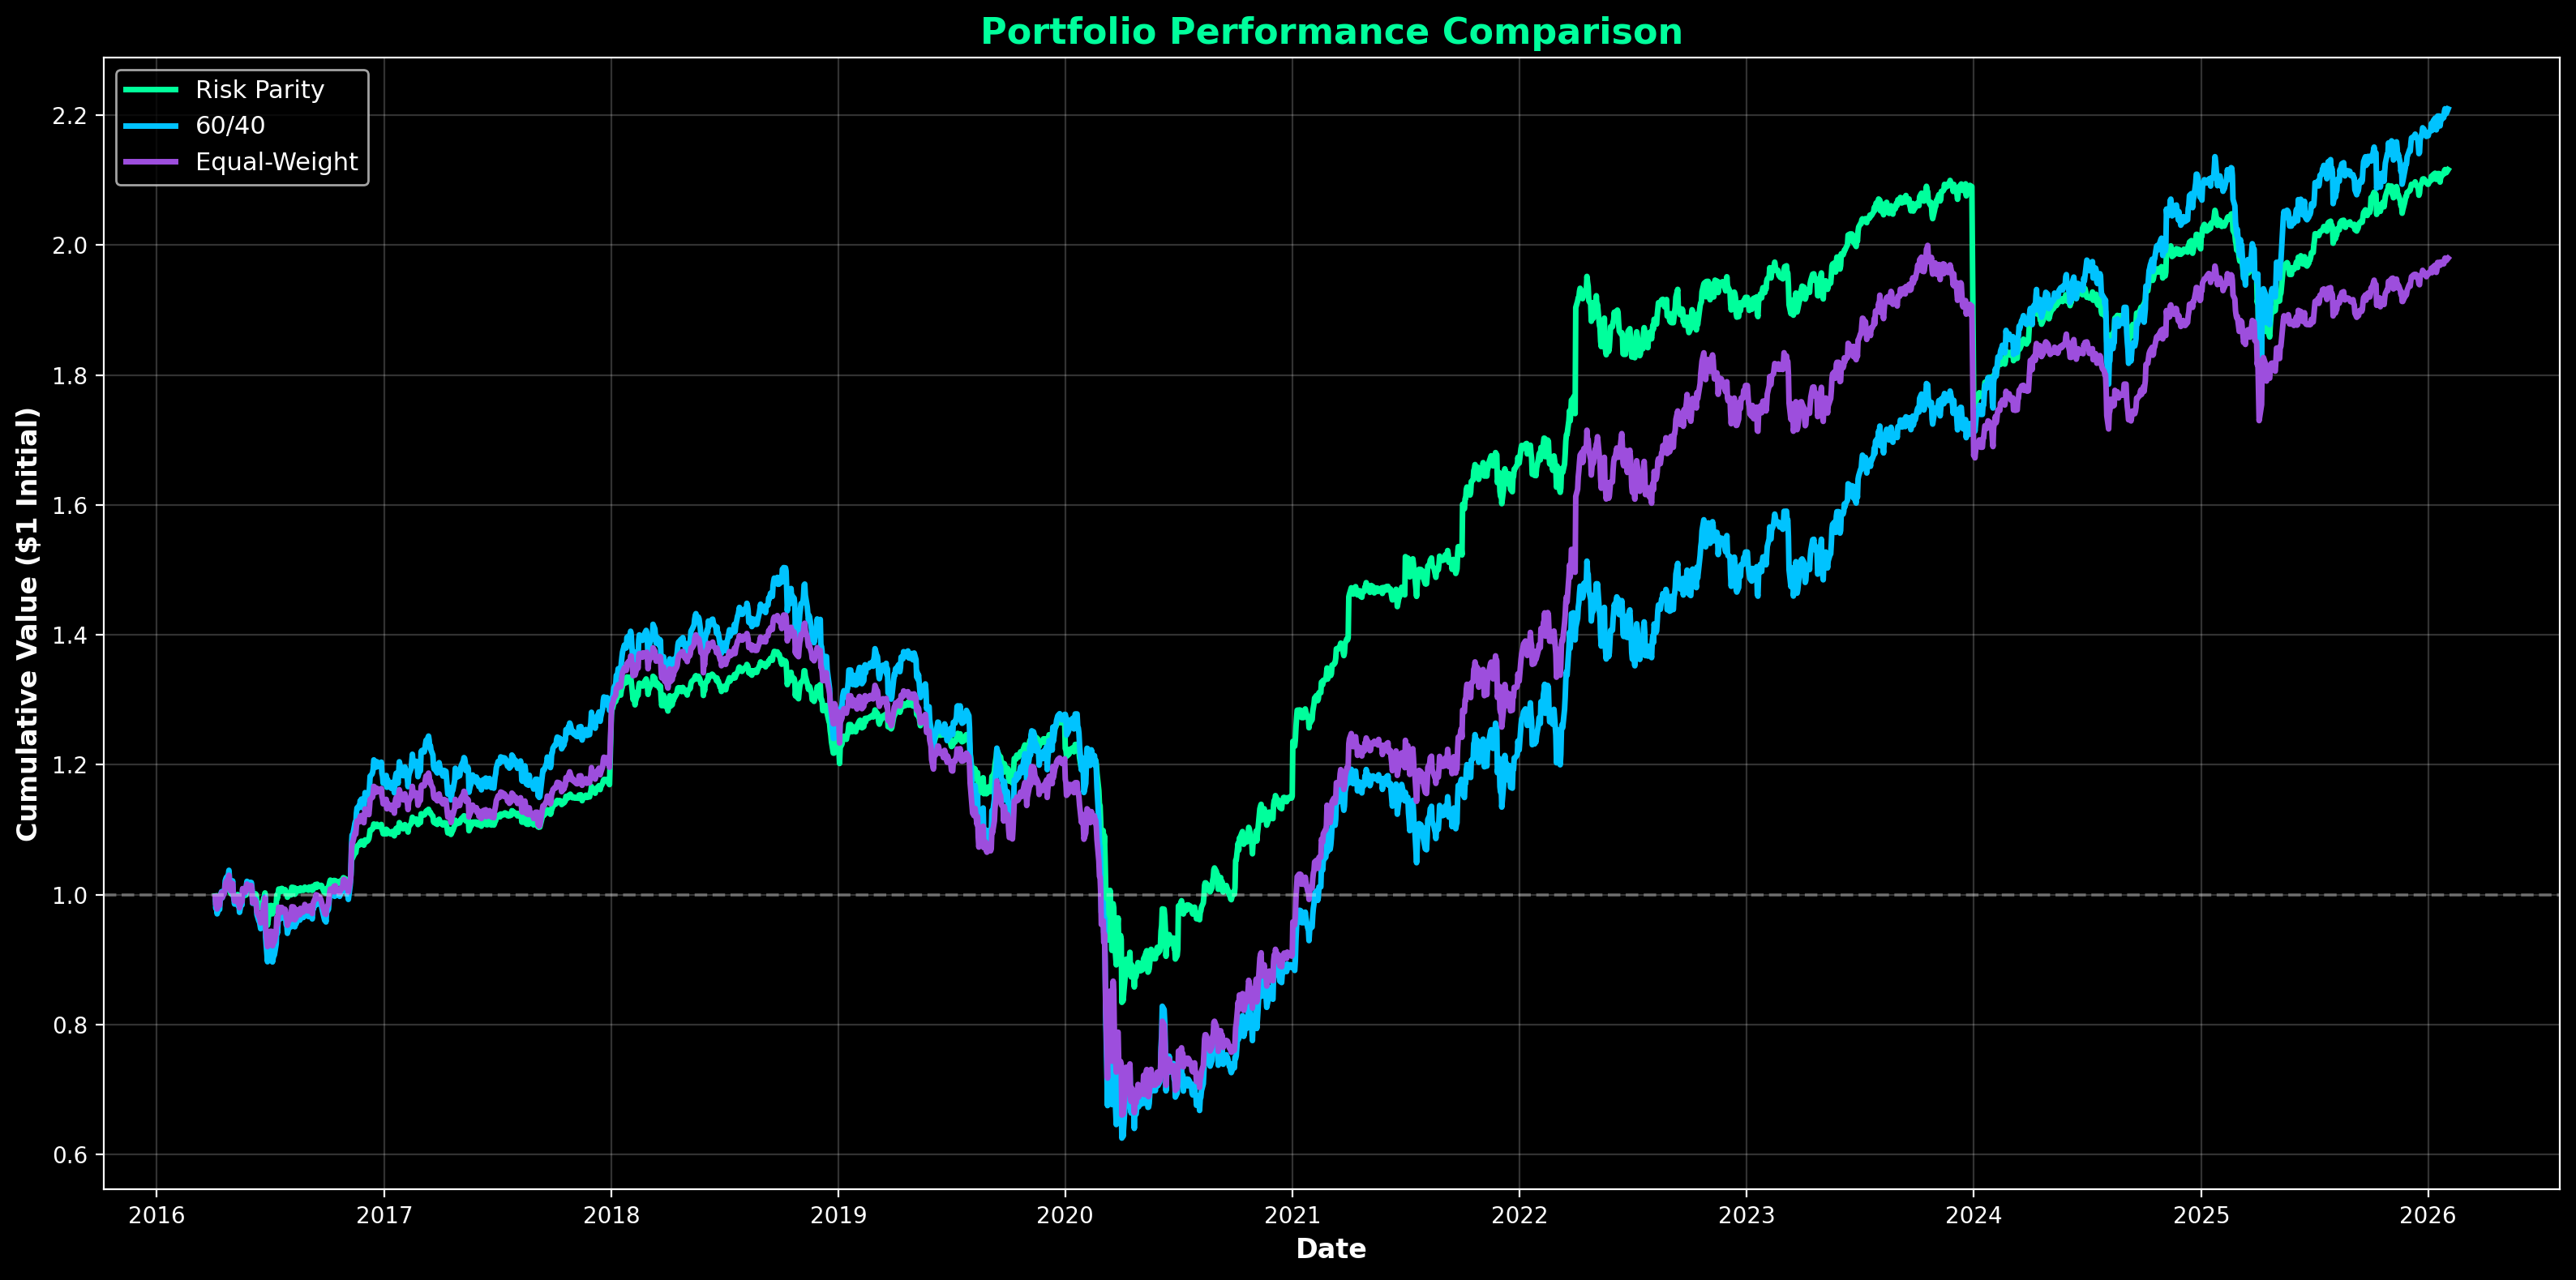

In [8]:
# Plot performance
viz = PortfolioVisualizer()
fig = viz.plot_portfolio_performance(performance, figsize=(16, 8))
plt.show()

## 3. Crisis Performance Analysis

In [33]:
# Define crisis periods (only use periods within your data range)
crisis_periods = {
    'GFC': ('2008-09-01', '2009-03-31'),
    'COVID': ('2020-02-01', '2020-04-30'),
    'Inflation': ('2022-01-01', '2022-12-31')
}

# Analyze each portfolio during crises
crisis_results = {}
for name, weights in strategies.items():
    crisis_perf = backtester.calculate_crisis_performance(weights, crisis_periods)
    crisis_results[name] = crisis_perf

print("✅ Crisis analysis complete")

✅ Crisis analysis complete


In [35]:
# Display crisis performance for each portfolio
for name, perf in crisis_results.items():
    print(f"\n{'='*60}")
    print(f"📊 {name} Portfolio - Crisis Performance")
    print(f"{'='*60}")
    print(perf.round(4))


📊 Risk Parity Portfolio - Crisis Performance
           Total Return  Volatility  Max Drawdown   Days
COVID           -0.2416      0.4960       -0.3124   64.0
Inflation        0.1534      0.1441       -0.0641  260.0

📊 60/40 Portfolio - Crisis Performance
           Total Return  Volatility  Max Drawdown   Days
COVID           -0.4049      0.9399       -0.4899   64.0
Inflation        0.2493      0.2090       -0.1065  260.0

📊 Equal-Weight Portfolio - Crisis Performance
           Total Return  Volatility  Max Drawdown   Days
COVID           -0.3556      0.7273       -0.4166   64.0
Inflation        0.3426      0.1717       -0.0694  260.0


## 4. Crisis-by-Crisis Comparison


Crises with data: ['COVID', 'Inflation']
Number of crises: 2

Crisis results for Risk Parity :
           Total Return  Volatility  Max Drawdown   Days
COVID         -0.241621    0.496030     -0.312436   64.0
Inflation      0.153376    0.144065     -0.064142  260.0


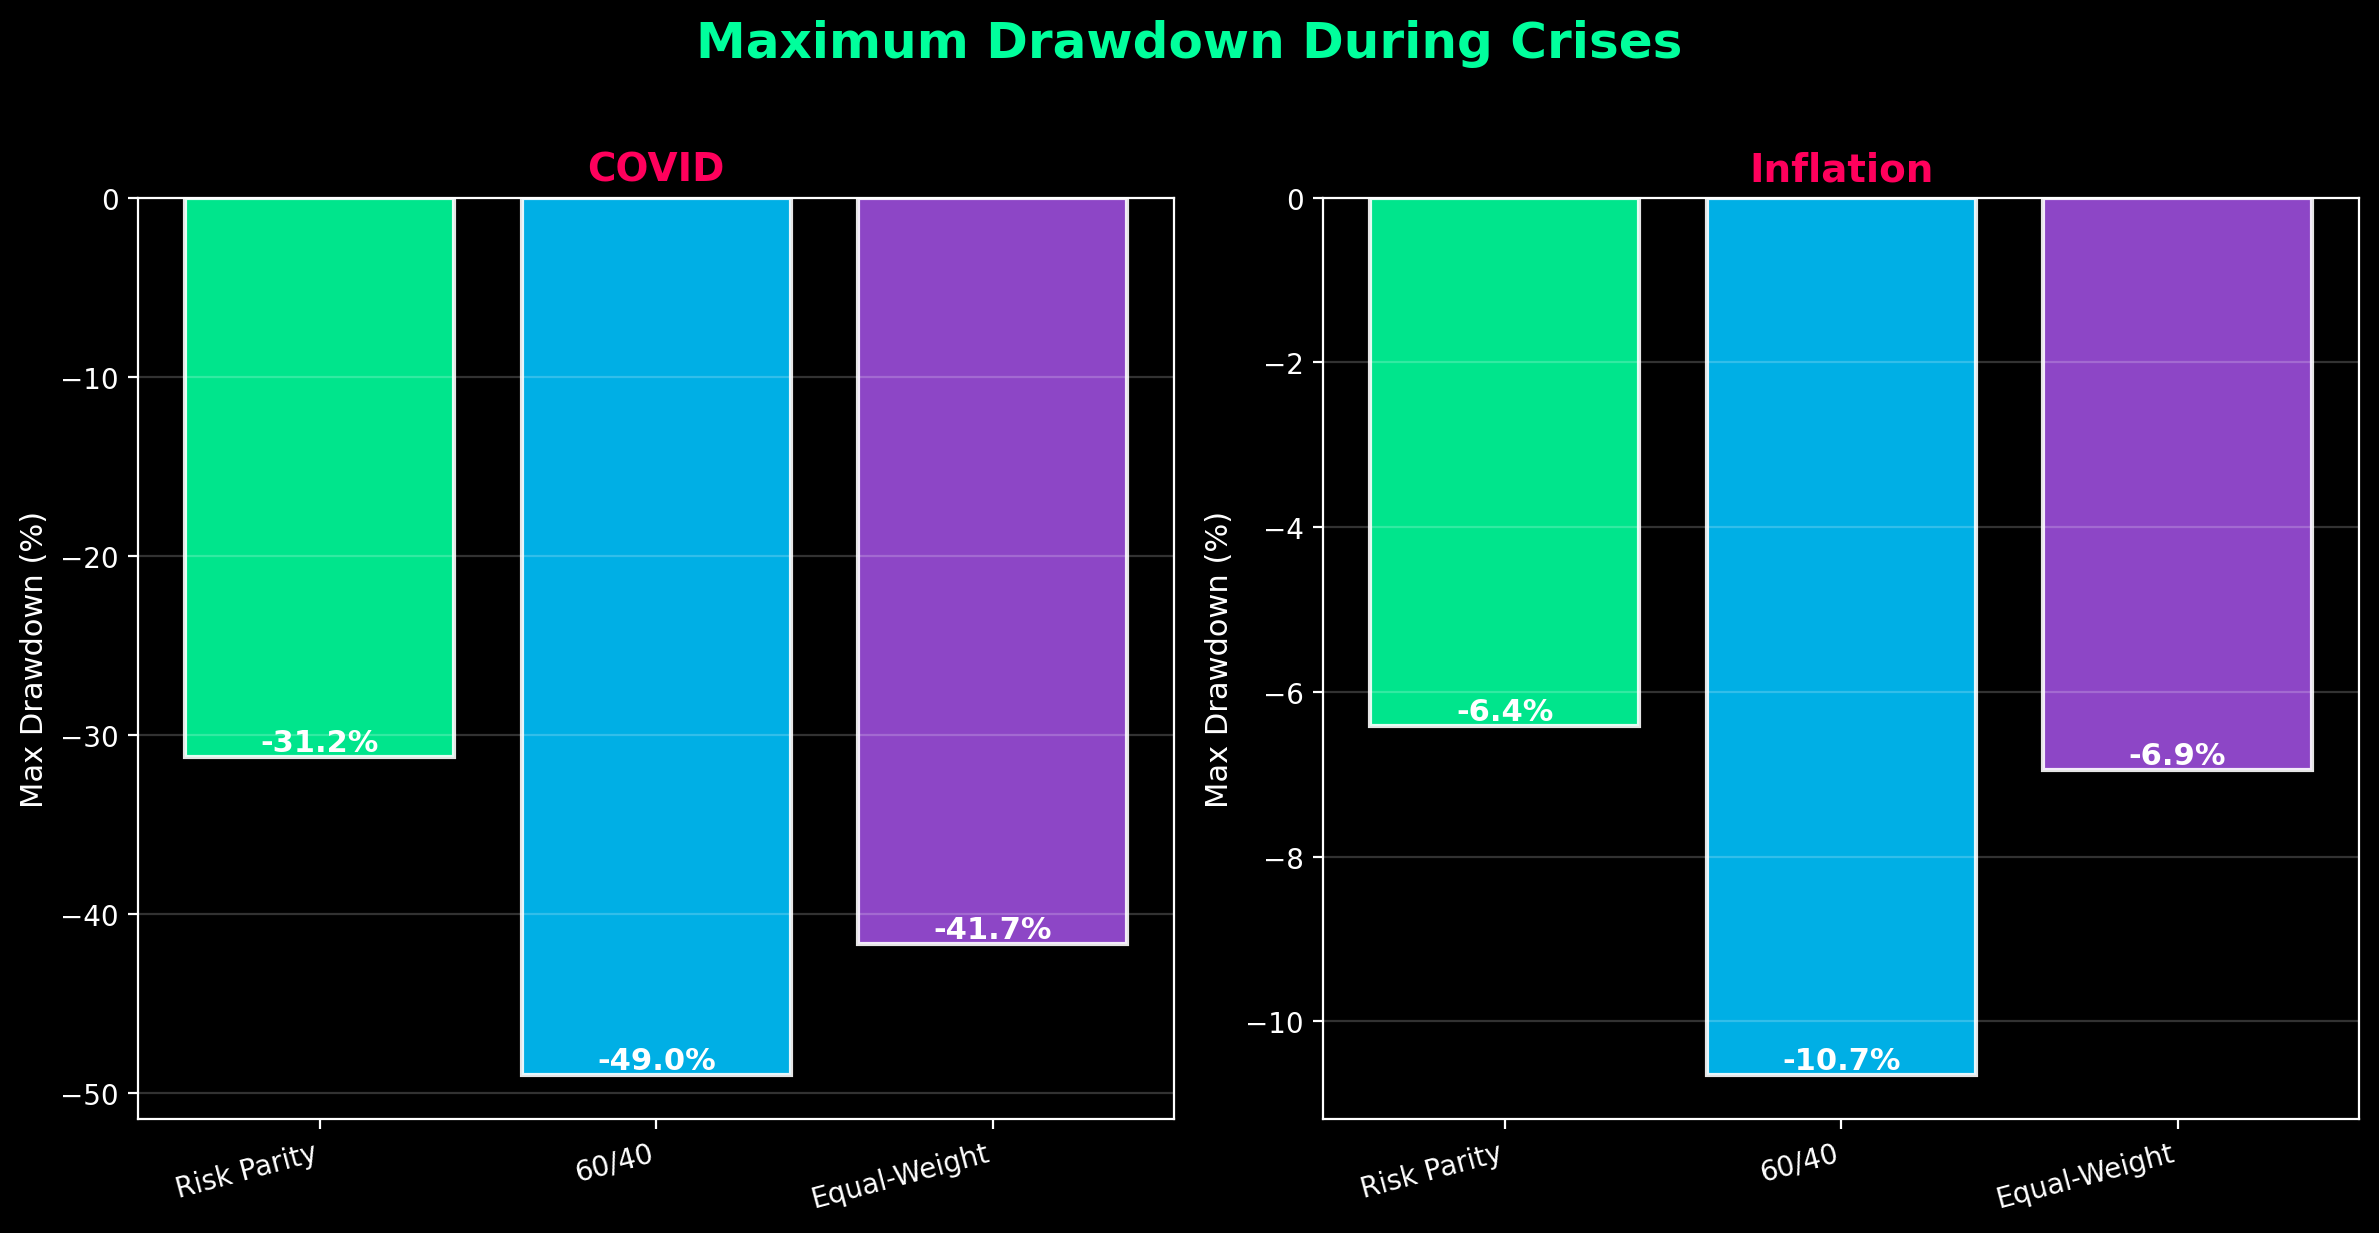

In [40]:
# Check which crises actually have data
first_portfolio = list(strategies.keys())[0]
actual_crises = list(crisis_results[first_portfolio].index)
print(f"\nCrises with data: {actual_crises}")
print(f"Number of crises: {len(actual_crises)}")

# Display the crisis results to debug
print("\nCrisis results for", first_portfolio, ":")
print(crisis_results[first_portfolio])

# Compare max drawdowns across crises
STONKS_PALETTE = [STONKS_GREEN, STONKS_BLUE, STONKS_PURP]

# Only create as many subplots as we have crises
n_crises = len(actual_crises)
fig, axes = plt.subplots(1, n_crises, figsize=(6*n_crises, 6))

# Handle case of single crisis (axes won't be array)
if n_crises == 1:
    axes = [axes]

for idx, crisis_name in enumerate(actual_crises):
    ax = axes[idx]
    
    drawdowns = []
    portfolio_names = []
    for name in strategies.keys():
        try:
            dd = crisis_results[name].loc[crisis_name, 'Max Drawdown']
            drawdowns.append(dd * 100)
            portfolio_names.append(name)
        except KeyError:
            print(f"Warning: {crisis_name} not found for {name}")
            continue
    
    if drawdowns:  # Only plot if we have data
        bars = ax.bar(portfolio_names, drawdowns, 
                      color=STONKS_PALETTE[:len(portfolio_names)],
                      edgecolor='white', linewidth=1.5, alpha=0.9)
        
        # Add labels
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%',
                   ha='center', va='bottom', 
                   fontsize=11, fontweight='bold', color='white')
        
        ax.set_title(crisis_name, fontsize=14, fontweight='bold', color=STONKS_RED)
        ax.set_ylabel('Max Drawdown (%)', fontsize=11)
        ax.grid(True, alpha=0.2, axis='y')
        ax.set_xticklabels(portfolio_names, rotation=15, ha='right')
    else:
        ax.text(0.5, 0.5, 'No Data', ha='center', va='center', 
                fontsize=14, color='white')
        ax.set_title(crisis_name, fontsize=14, fontweight='bold', color=STONKS_RED)

plt.suptitle('Maximum Drawdown During Crises', 
            fontsize=18, fontweight='bold', color=STONKS_GREEN, y=1.02)
plt.tight_layout()
plt.show()

## 5. Drawdown Comparison (Full History)

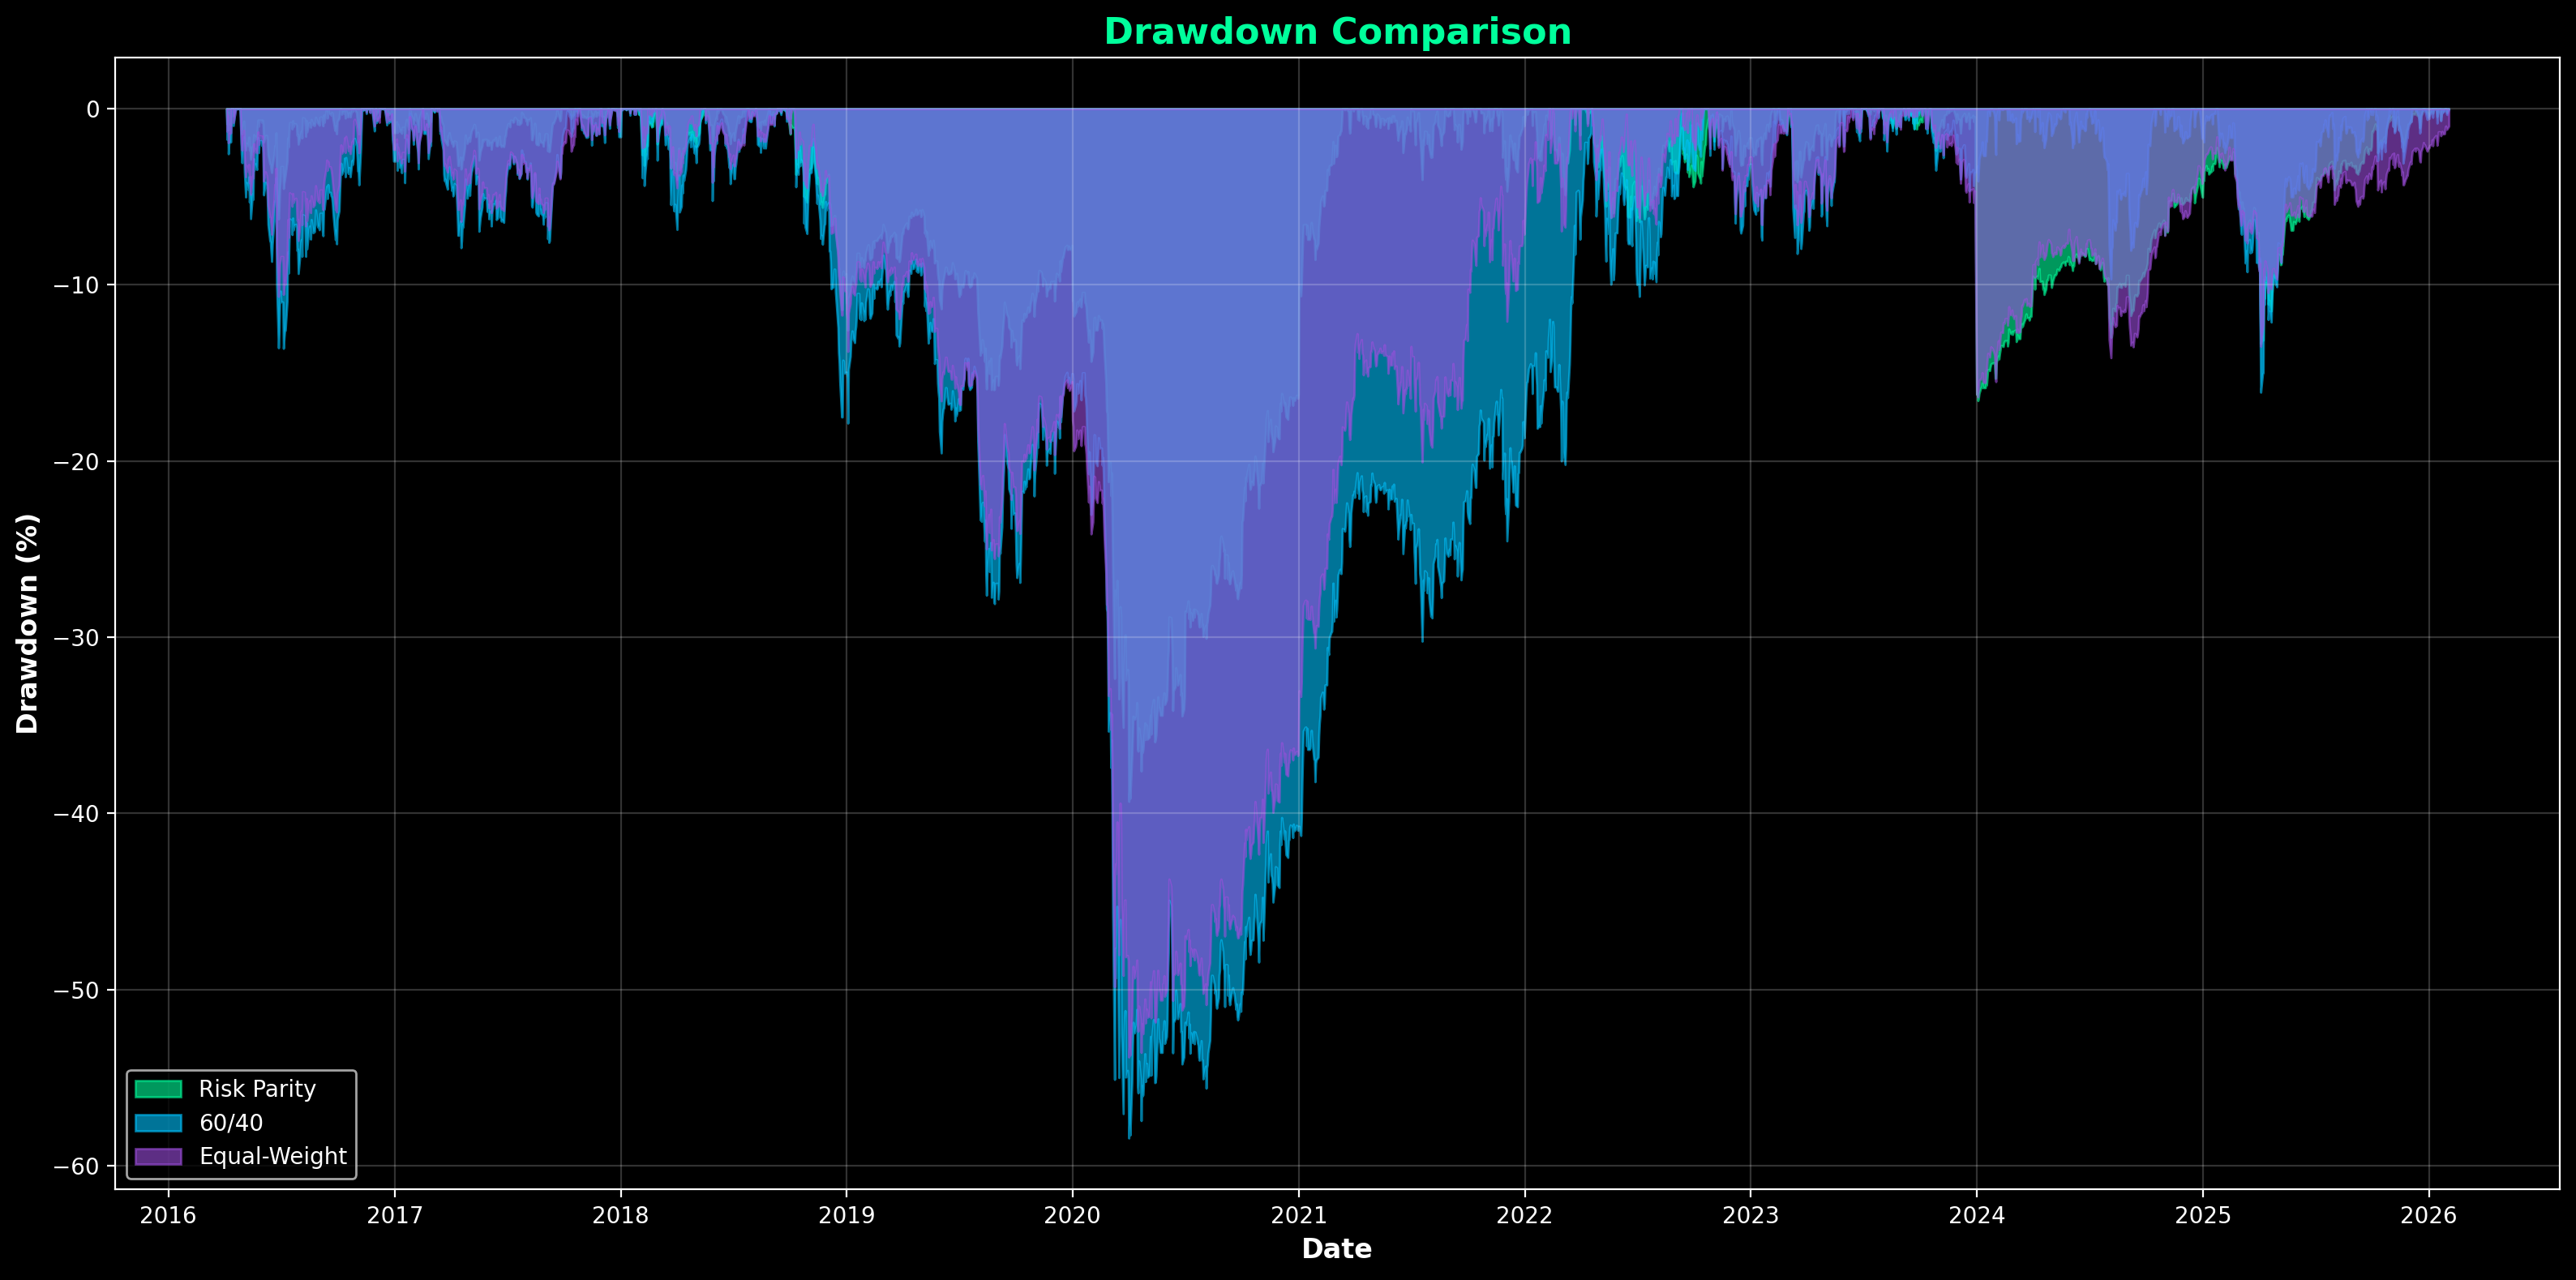

In [42]:
# Calculate drawdown series for all portfolios
drawdowns = {}
for name, weights in strategies.items():
    dd = backtester.calculate_drawdown_series(weights)
    drawdowns[name] = dd

# Plot
fig = viz.plot_drawdown_comparison(drawdowns, figsize=(16, 8))
plt.show()

## 6. Summary Statistics

In [44]:
# Calculate comprehensive statistics
summary_stats = {}

for name, weights in strategies.items():
    stats = backtester.get_summary_statistics(weights)
    summary_stats[name] = stats

summary_df = pd.DataFrame(summary_stats).T

print("\n📊 PORTFOLIO SUMMARY STATISTICS:")
print("="*80)
print(summary_df)
print("="*80)


📊 PORTFOLIO SUMMARY STATISTICS:
             Annualized Return Annualized Volatility Sharpe Ratio  \
Risk Parity              8.40%                14.30%        0.587   
60/40                   10.56%                23.42%        0.451   
Equal-Weight             8.51%                18.90%        0.450   

             Maximum Drawdown Best Day Worst Day Win Rate Total Days  
Risk Parity           -39.32%    9.38%   -15.83%   52.84%       2566  
60/40                 -58.43%   16.87%   -17.77%   51.95%       2566  
Equal-Weight          -53.83%   13.09%   -13.14%   51.52%       2566  


## 7. Risk-Return Visualization

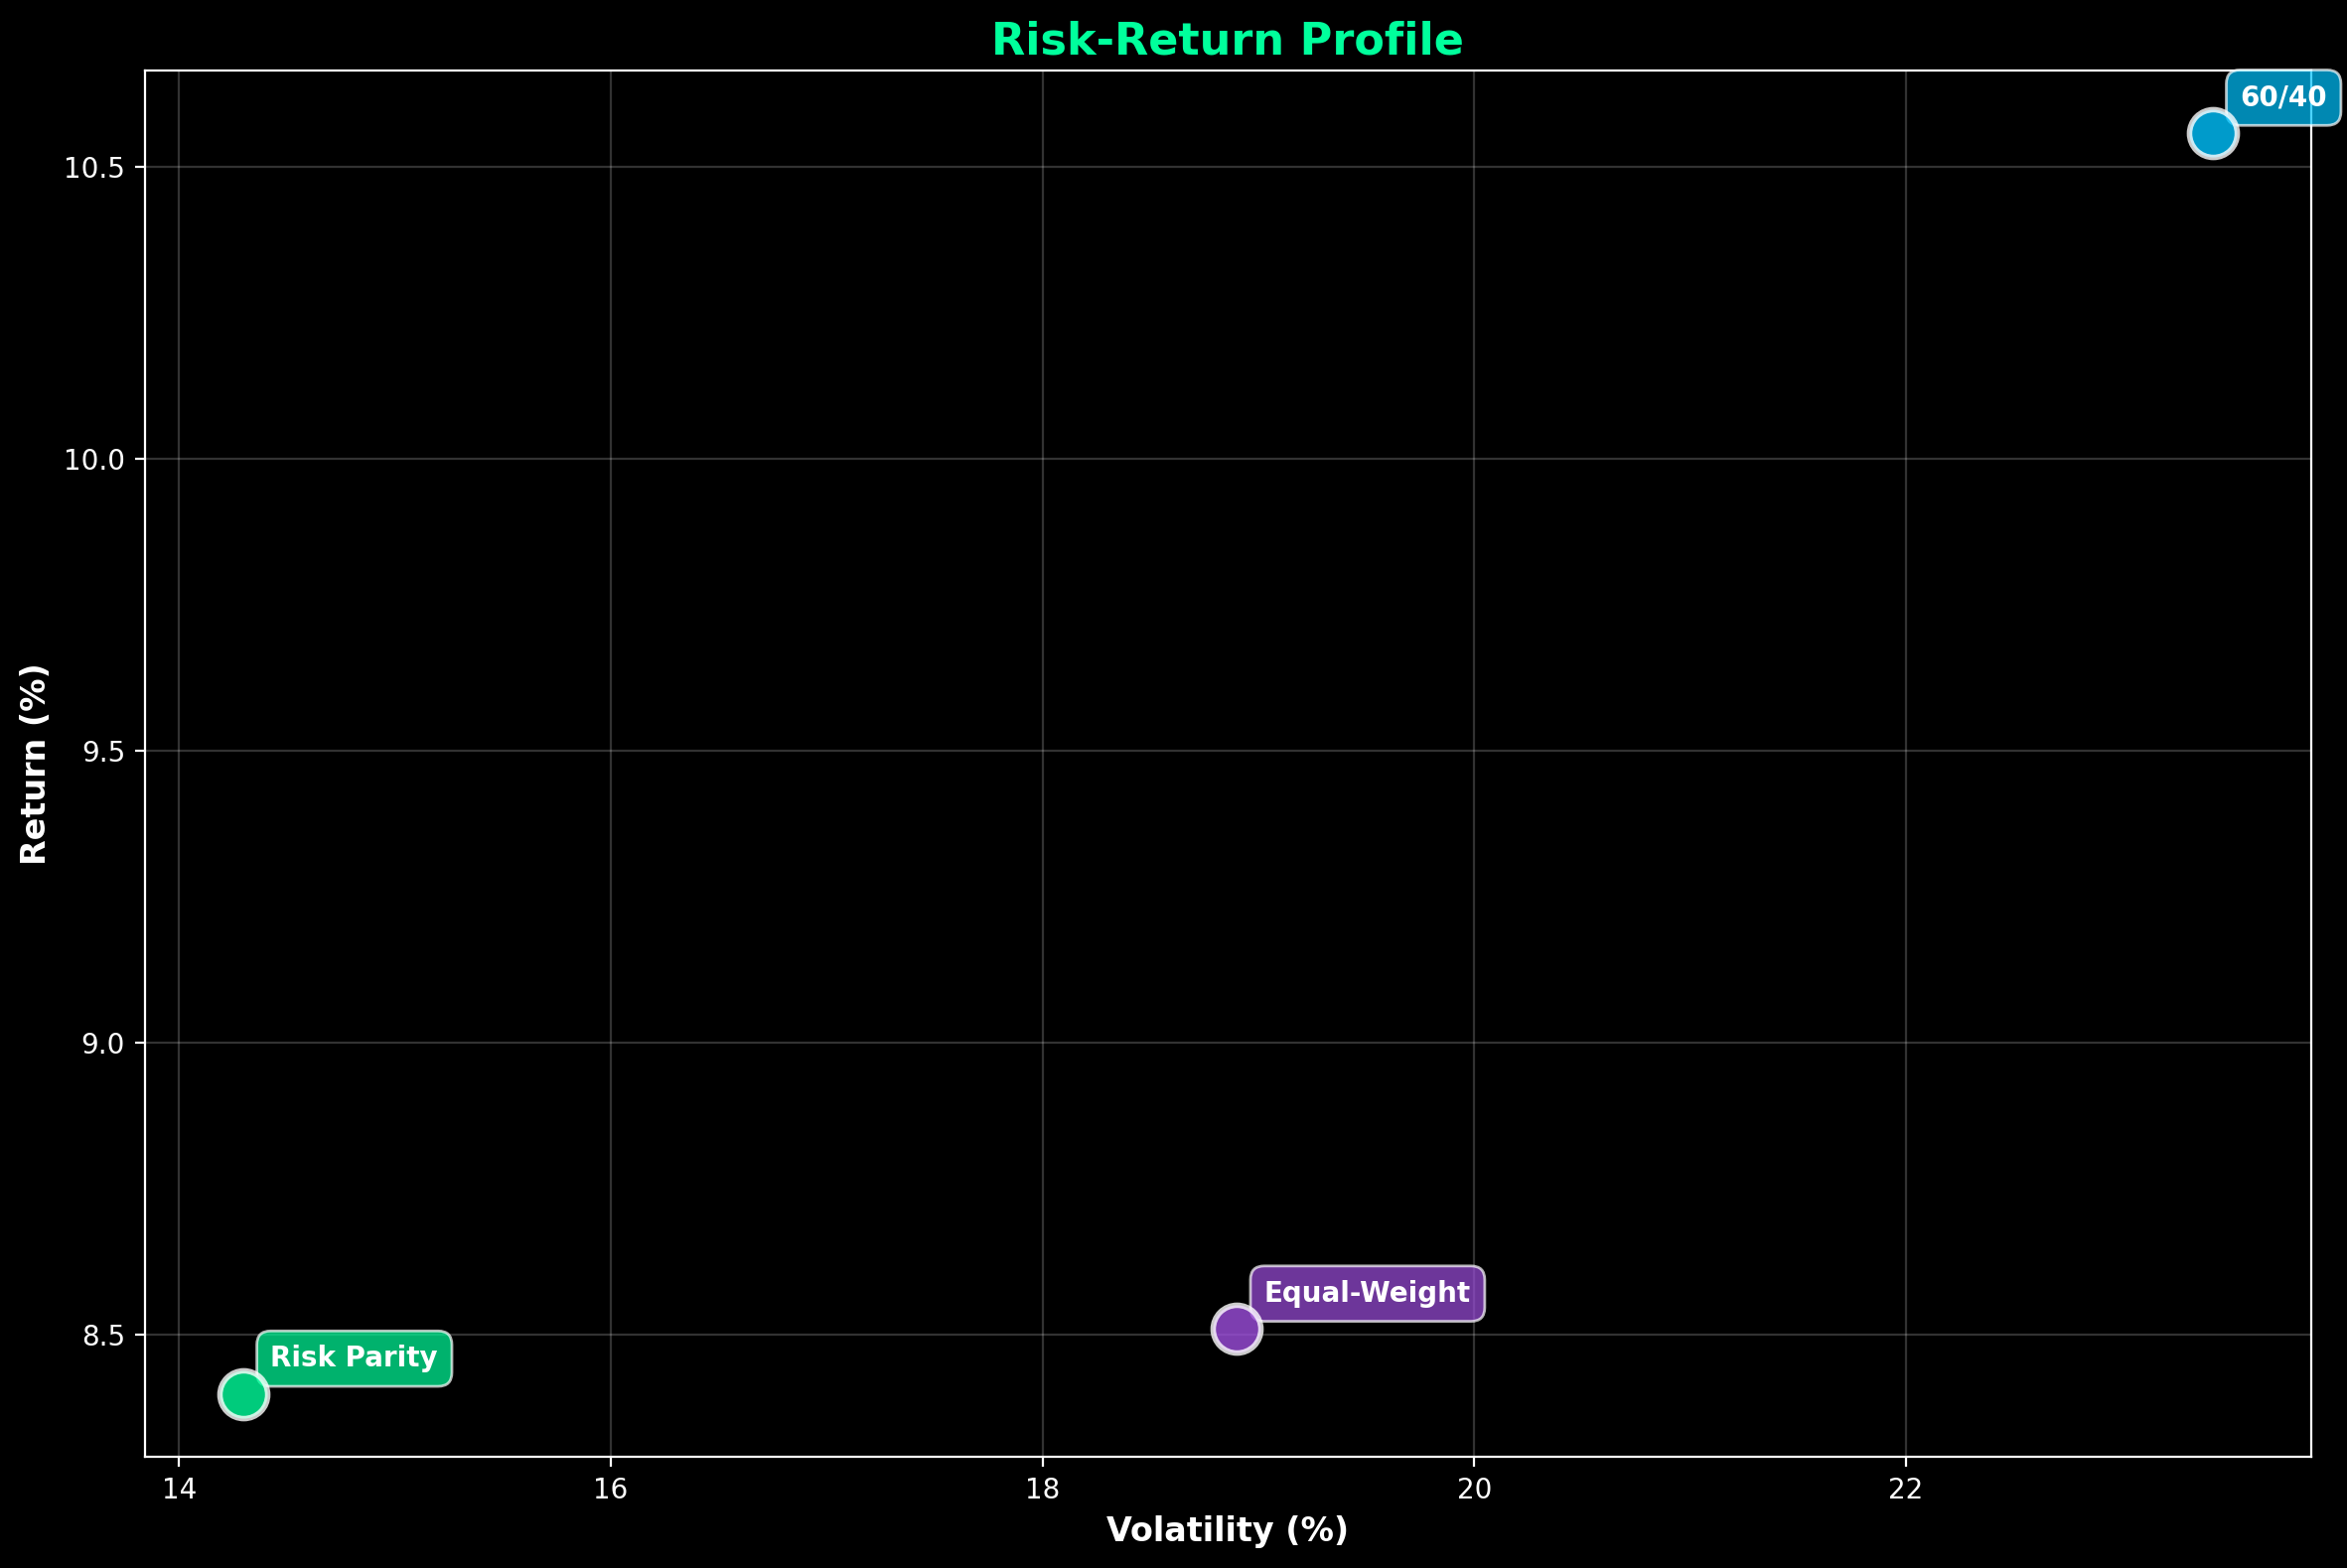

In [46]:
# Extract metrics for risk-return plot
metrics_dict = {}

for name, weights in strategies.items():
    portfolio_returns = (returns * weights).sum(axis=1)
    
    annual_return = portfolio_returns.mean() * 252
    annual_vol = portfolio_returns.std() * np.sqrt(252)
    
    metrics_dict[name] = {
        'return': annual_return,
        'volatility': annual_vol
    }

# Plot
fig = viz.plot_efficient_frontier_overlay(metrics_dict, figsize=(12, 8))
plt.show()

## 8. Rolling Sharpe Ratio Comparison

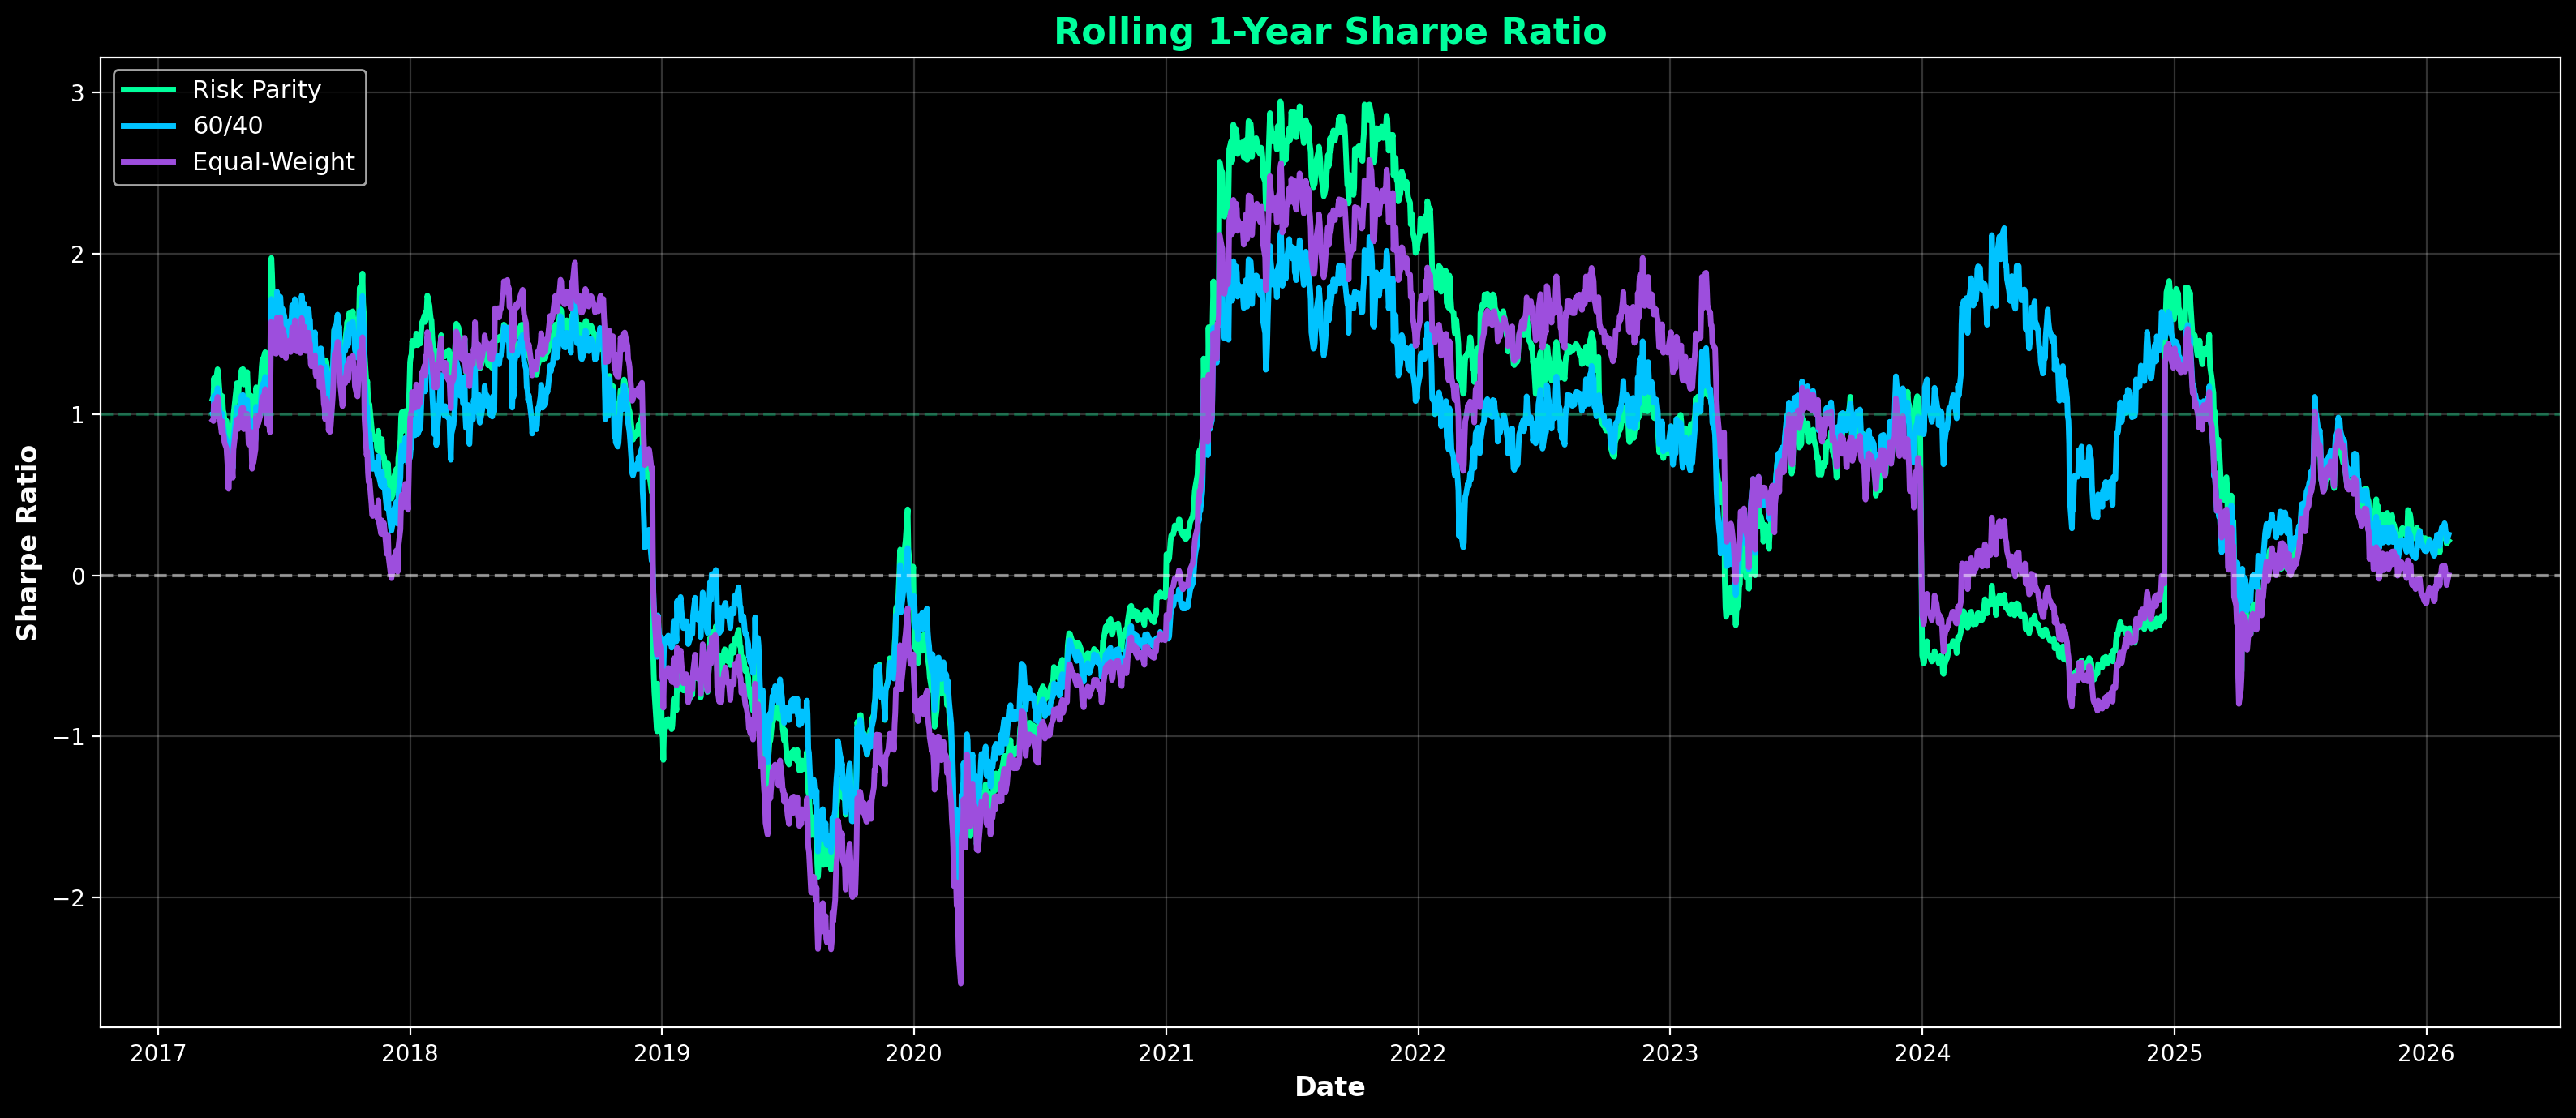

In [48]:
# Calculate rolling Sharpe ratios
fig, ax = plt.subplots(figsize=(16, 7))

for i, (name, weights) in enumerate(strategies.items()):
    rolling_sharpe = backtester.rolling_sharpe_ratio(weights, window=252)
    ax.plot(rolling_sharpe.index, rolling_sharpe, 
           label=name, linewidth=2.5,
           color=STONKS_PALETTE[i])

ax.set_title('Rolling 1-Year Sharpe Ratio', 
            fontsize=16, fontweight='bold', color=STONKS_GREEN)
ax.set_xlabel('Date', fontsize=12, fontweight='bold', color='white')
ax.set_ylabel('Sharpe Ratio', fontsize=12, fontweight='bold', color='white')
ax.legend(loc='upper left', framealpha=0.8, fontsize=11)
ax.grid(True, alpha=0.2)
ax.axhline(y=0, color='white', linestyle='--', alpha=0.5)
ax.axhline(y=1, color=STONKS_GREEN, linestyle='--', alpha=0.3, label='Sharpe = 1.0')

plt.tight_layout()
plt.show()

## 9. Final Analysis & Key Insights

In [50]:
print("\n" + "="*80)
print("🔍 COMPREHENSIVE PORTFOLIO ANALYSIS")
print("="*80)

# Performance comparison
print("\n1️⃣ TOTAL RETURNS:")
for name in strategies.keys():
    total_return = (performance[name].iloc[-1] - 1) * 100
    print(f"   • {name:15s}: {total_return:7.2f}%")

# Volatility comparison
print("\n2️⃣ ANNUALIZED VOLATILITY:")
for name, weights in strategies.items():
    vol = RiskModels.calculate_portfolio_volatility(weights, cov_matrix)
    print(f"   • {name:15s}: {vol:7.2%}")

# Sharpe ratios
print("\n3️⃣ SHARPE RATIOS:")
for name, weights in strategies.items():
    portfolio_returns = (returns * weights).sum(axis=1)
    sharpe = RiskModels.calculate_sharpe_ratio(portfolio_returns)
    print(f"   • {name:15s}: {sharpe:7.3f}")

# Max drawdowns
print("\n4️⃣ MAXIMUM DRAWDOWNS:")
for name, dd_series in drawdowns.items():
    max_dd = dd_series.min() * 100
    print(f"   • {name:15s}: {max_dd:7.2f}%")

print("\n" + "="*80)
print("\n💡 KEY INSIGHTS:")
print("="*80)
print("""
1. RISK PARITY ADVANTAGES:
   ✓ More balanced risk exposure across asset classes
   ✓ Better downside protection during equity crashes
   ✓ Lower overall portfolio volatility
   ✓ More consistent Sharpe ratio over time

2. 60/40 CHARACTERISTICS:
   • Dominated by equity risk (SPY contributes 80%+ of risk)
   • Vulnerable to equity crashes
   • Higher volatility despite 40% bonds

3. EQUAL-WEIGHT ISSUES:
   • Still unbalanced in risk terms
   • High volatility assets dominate risk contribution
   • Not truly diversified

4. CRISIS PERFORMANCE:
   • Risk Parity shows superior drawdown control
   • Faster recovery after market shocks
   • More stable performance across different regimes
""")
print("="*80)


🔍 COMPREHENSIVE PORTFOLIO ANALYSIS

1️⃣ TOTAL RETURNS:
   • Risk Parity    :  111.61%
   • 60/40          :  120.97%
   • Equal-Weight   :   97.99%

2️⃣ ANNUALIZED VOLATILITY:
   • Risk Parity    :  14.30%
   • 60/40          :  23.42%
   • Equal-Weight   :  18.90%

3️⃣ SHARPE RATIOS:
   • Risk Parity    :   0.448
   • 60/40          :   0.365
   • Equal-Weight   :   0.344

4️⃣ MAXIMUM DRAWDOWNS:
   • Risk Parity    :  -39.32%
   • 60/40          :  -58.43%
   • Equal-Weight   :  -53.83%


💡 KEY INSIGHTS:

1. RISK PARITY ADVANTAGES:
   ✓ More balanced risk exposure across asset classes
   ✓ Better downside protection during equity crashes
   ✓ Lower overall portfolio volatility
   ✓ More consistent Sharpe ratio over time

2. 60/40 CHARACTERISTICS:
   • Dominated by equity risk (SPY contributes 80%+ of risk)
   • Vulnerable to equity crashes
   • Higher volatility despite 40% bonds

3. EQUAL-WEIGHT ISSUES:
   • Still unbalanced in risk terms
   • High volatility assets dominate risk co